# **Imports**

In [1]:
import torch
import torchvision
import torch.nn as nn  
import torch.optim as optim  
import torch.nn.functional as F  
from torch.utils.data import (
    DataLoader,
    Dataset,
) 
import torchvision.datasets as datasets
import torchvision.transforms as transforms 
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!tar -xvzf "/content/drive/MyDrive/lens_data_alt.tgz";

# **Load Data**

In [21]:
train_transforms = transforms.Compose([
        transforms.Lambda(lambda x: x.to(torch.float32).repeat(3,1,1)),
        transforms.Resize((224,224)),
        transforms.Lambda(lambda x: x - x.min() / x.max() - x.min()),
        transforms.RandomHorizontalFlip(p = 0.5),
        transforms.RandomVerticalFlip(p = 0.5),
        ])
test_transforms = transforms.Compose([
        transforms.Lambda(lambda x: x.to(torch.float32).repeat(3,1,1)),
        transforms.Resize((224,224)),
        transforms.Lambda(lambda x: x - x.min() / x.max() - x.min())
        ])

In [22]:
path = "/content/lens_data"
class MyDataset(Dataset):
  def __init__(self, path=path, train_transform=train_transforms,test_transform = test_transforms, mode=None):
    self.path = path
    self.data_files = os.listdir(path)
    self.data_files.sort()

    self.train_transform = train_transforms
    self.test_transform = test_transforms

    train_images, test_images = train_test_split(self.data_files, test_size = 0.2, random_state = 666)
    self.train_images = train_images
    self.test_images = test_images

    self.mode = mode

  def __len__(self):
    if self.mode == 'train':
      return len(self.train_images)
    elif self.mode == 'test':
      return len(self.test_images)

  def __getitem__(self, index):
    if self.mode == 'train':
      data = np.load(os.path.join(self.path, self.train_images[index]),allow_pickle=True)
      image,mass = torch.tensor(data[0], dtype=torch.float32) , torch.tensor(data[1], dtype=torch.float32)

      image = self.train_transform(image)

      return image,mass

    elif self.mode == 'test':
      data = np.load(os.path.join(self.path,self.test_images[index]),allow_pickle=True)
      image,mass = torch.tensor(data[0], dtype=torch.float32) , torch.tensor(data[1], dtype=torch.float32)

      image = self.test_transform(image)

      return image,mass

In [23]:
train_dataset = MyDataset(mode = 'train')
test_dataset = MyDataset(mode = 'test')

total_count = len(test_dataset)
test_count = int(0.5 * total_count)
val_count = total_count - test_count
test_dataset, val_dataset = torch.utils.data.random_split(
    test_dataset, (test_count, val_count)
)



train_loader = DataLoader(train_dataset, batch_size=32,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32,shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False)

# **Define Model**

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.mobilenet_v3_large(weights = True)


model.classifier = nn.Sequential(
    nn.Linear(960, 1)
)
model.to(device);

In [25]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=4e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=2,verbose=True)

In [26]:
import gc
gc.collect()
torch.cuda.empty_cache()

# **Evaluataion Function**

In [27]:
def evaluate(model, dataloader, criterion):
    losses = []
    all_targets = []
    all_scores = []

    model.eval()

    with torch.no_grad():
        for data, targets in dataloader:

            data = data.to(device=device)
            targets = targets.to(device=device)

            scores = model(data).squeeze()
            loss = criterion(scores, targets.squeeze(0))

            losses.append(loss.item())
            all_targets.extend(targets.cpu().numpy())
            all_scores.extend(scores.detach().cpu().numpy())

        avg_loss = sum(losses) / len(losses)

        
        y_pred = np.array(all_scores)
        y_true = np.array(all_targets)

         

    return avg_loss, y_pred, y_true

# **Training**

In [30]:
best_val_loss = 1

for epoch in range(80):
  losses = []
  all_targets = []
  all_scores = []

  # set model to training mode
  model.train()

  for data, targets in tqdm(train_loader):
  
    data = data.to(device=device)
    targets = targets.to(device=device)

    # forward
    scores = model(data).squeeze()
    loss = criterion(scores, targets.squeeze(0))

    losses.append(loss.item())

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  avg_loss_train = sum(losses) / len(losses)
  all_targets.extend(targets.cpu().numpy())
  all_scores.extend(scores.detach().cpu().numpy())

    
  avg_loss_val, _ ,_ = evaluate(model,val_loader,criterion)
  scheduler.step(avg_loss_val)
    

  if avg_loss_val < best_val_loss:
    # Update the best validation loss
    best_val_loss = avg_loss_val

    # Save the model state dictionary and other information
    torch.save({
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'val_loss': avg_loss_val
    }, "/content/the_best_model.pth")

  print(f"\nEpoch No. {epoch+1}\n======\n")
  print(f"Training Loss is {avg_loss_train:.15f}, Validation Loss is {avg_loss_val:.15f}")
  print("===============\n")

100%|██████████| 500/500 [01:16<00:00,  6.56it/s]



Epoch No. 1

Training Loss is 0.000212095657320, Validation Loss is 0.000179752205787



100%|██████████| 500/500 [01:15<00:00,  6.63it/s]



Epoch No. 2

Training Loss is 0.000192224464008, Validation Loss is 0.000287164371998



100%|██████████| 500/500 [01:14<00:00,  6.68it/s]



Epoch No. 3

Training Loss is 0.000180913674492, Validation Loss is 0.000162524202125



100%|██████████| 500/500 [01:15<00:00,  6.66it/s]



Epoch No. 4

Training Loss is 0.000179372818740, Validation Loss is 0.000148783850212



100%|██████████| 500/500 [01:14<00:00,  6.75it/s]



Epoch No. 5

Training Loss is 0.000159022432425, Validation Loss is 0.000128004851643



100%|██████████| 500/500 [01:14<00:00,  6.73it/s]



Epoch No. 6

Training Loss is 0.000143412735721, Validation Loss is 0.000286859874558



100%|██████████| 500/500 [01:15<00:00,  6.64it/s]



Epoch No. 7

Training Loss is 0.000149935652844, Validation Loss is 0.000121977899176



100%|██████████| 500/500 [01:14<00:00,  6.70it/s]



Epoch No. 8

Training Loss is 0.000134684172735, Validation Loss is 0.000105214767650



100%|██████████| 500/500 [01:22<00:00,  6.08it/s]



Epoch No. 9

Training Loss is 0.000131067422197, Validation Loss is 0.000174388869103



100%|██████████| 500/500 [01:21<00:00,  6.13it/s]



Epoch No. 10

Training Loss is 0.000119503463939, Validation Loss is 0.000102137557752



100%|██████████| 500/500 [01:16<00:00,  6.56it/s]



Epoch No. 11

Training Loss is 0.000123639704580, Validation Loss is 0.000111527794428



100%|██████████| 500/500 [01:15<00:00,  6.61it/s]



Epoch No. 12

Training Loss is 0.000110512356725, Validation Loss is 0.000125952365731



100%|██████████| 500/500 [01:15<00:00,  6.66it/s]


Epoch 00016: reducing learning rate of group 0 to 3.6000e-04.

Epoch No. 13

Training Loss is 0.000101116072918, Validation Loss is 0.000196730416815



100%|██████████| 500/500 [01:15<00:00,  6.62it/s]



Epoch No. 14

Training Loss is 0.000098469808458, Validation Loss is 0.000095305457170



100%|██████████| 500/500 [01:14<00:00,  6.70it/s]



Epoch No. 15

Training Loss is 0.000093659097380, Validation Loss is 0.000098147549752



100%|██████████| 500/500 [01:15<00:00,  6.61it/s]



Epoch No. 16

Training Loss is 0.000087512015074, Validation Loss is 0.000106751456596



100%|██████████| 500/500 [01:16<00:00,  6.57it/s]



Epoch No. 17

Training Loss is 0.000088440728752, Validation Loss is 0.000087707791820



100%|██████████| 500/500 [01:15<00:00,  6.61it/s]



Epoch No. 18

Training Loss is 0.000087823668575, Validation Loss is 0.000093163677876



100%|██████████| 500/500 [01:15<00:00,  6.58it/s]



Epoch No. 19

Training Loss is 0.000080570893006, Validation Loss is 0.000085811619231



100%|██████████| 500/500 [01:15<00:00,  6.62it/s]



Epoch No. 20

Training Loss is 0.000078715508287, Validation Loss is 0.000079374885986



100%|██████████| 500/500 [01:15<00:00,  6.61it/s]



Epoch No. 21

Training Loss is 0.000074017216539, Validation Loss is 0.000098206264305



100%|██████████| 500/500 [01:16<00:00,  6.54it/s]



Epoch No. 22

Training Loss is 0.000068086694660, Validation Loss is 0.000105584372322



100%|██████████| 500/500 [01:15<00:00,  6.62it/s]


Epoch 00026: reducing learning rate of group 0 to 3.2400e-04.

Epoch No. 23

Training Loss is 0.000070414066311, Validation Loss is 0.000165042621019



100%|██████████| 500/500 [01:15<00:00,  6.59it/s]



Epoch No. 24

Training Loss is 0.000061617566575, Validation Loss is 0.000091068056737



100%|██████████| 500/500 [01:15<00:00,  6.62it/s]



Epoch No. 25

Training Loss is 0.000057346557551, Validation Loss is 0.000120287015018



100%|██████████| 500/500 [01:15<00:00,  6.63it/s]



Epoch No. 26

Training Loss is 0.000056793582426, Validation Loss is 0.000071969160398



100%|██████████| 500/500 [01:16<00:00,  6.57it/s]



Epoch No. 27

Training Loss is 0.000054980188954, Validation Loss is 0.000065822695130



100%|██████████| 500/500 [01:15<00:00,  6.60it/s]



Epoch No. 28

Training Loss is 0.000050529060638, Validation Loss is 0.000076844162755



100%|██████████| 500/500 [01:16<00:00,  6.53it/s]



Epoch No. 29

Training Loss is 0.000052050121049, Validation Loss is 0.000120129886440



100%|██████████| 500/500 [01:15<00:00,  6.59it/s]


Epoch 00033: reducing learning rate of group 0 to 2.9160e-04.

Epoch No. 30

Training Loss is 0.000049667840573, Validation Loss is 0.000339071034677



100%|██████████| 500/500 [01:15<00:00,  6.60it/s]



Epoch No. 31

Training Loss is 0.000044066559196, Validation Loss is 0.000072620015364



100%|██████████| 500/500 [01:16<00:00,  6.56it/s]



Epoch No. 32

Training Loss is 0.000044621716490, Validation Loss is 0.000066598419792



100%|██████████| 500/500 [01:15<00:00,  6.59it/s]



Epoch No. 33

Training Loss is 0.000041144330302, Validation Loss is 0.000064966847161



100%|██████████| 500/500 [01:16<00:00,  6.57it/s]



Epoch No. 34

Training Loss is 0.000043075970612, Validation Loss is 0.000109872313000



100%|██████████| 500/500 [01:15<00:00,  6.61it/s]



Epoch No. 35

Training Loss is 0.000040555668131, Validation Loss is 0.000070335072595



100%|██████████| 500/500 [01:16<00:00,  6.57it/s]


Epoch 00039: reducing learning rate of group 0 to 2.6244e-04.

Epoch No. 36

Training Loss is 0.000039265098603, Validation Loss is 0.000092419935610



100%|██████████| 500/500 [01:15<00:00,  6.60it/s]



Epoch No. 37

Training Loss is 0.000036514309575, Validation Loss is 0.000070195552585



100%|██████████| 500/500 [01:15<00:00,  6.60it/s]



Epoch No. 38

Training Loss is 0.000035413689635, Validation Loss is 0.000066186993233



100%|██████████| 500/500 [01:16<00:00,  6.54it/s]



Epoch No. 39

Training Loss is 0.000034017864587, Validation Loss is 0.000063351458107



100%|██████████| 500/500 [01:16<00:00,  6.57it/s]



Epoch No. 40

Training Loss is 0.000033542902916, Validation Loss is 0.000064159422335



100%|██████████| 500/500 [01:16<00:00,  6.53it/s]



Epoch No. 41

Training Loss is 0.000030444596892, Validation Loss is 0.000136743040269



100%|██████████| 500/500 [01:15<00:00,  6.59it/s]


Epoch 00045: reducing learning rate of group 0 to 2.3620e-04.

Epoch No. 42

Training Loss is 0.000031292331083, Validation Loss is 0.000064418986320



100%|██████████| 500/500 [01:15<00:00,  6.62it/s]



Epoch No. 43

Training Loss is 0.000030097467390, Validation Loss is 0.000066333328360



100%|██████████| 500/500 [01:16<00:00,  6.55it/s]



Epoch No. 44

Training Loss is 0.000026796970884, Validation Loss is 0.000067420419631



100%|██████████| 500/500 [01:15<00:00,  6.65it/s]


Epoch 00048: reducing learning rate of group 0 to 2.1258e-04.

Epoch No. 45

Training Loss is 0.000026213757848, Validation Loss is 0.000097559820764



100%|██████████| 500/500 [01:15<00:00,  6.60it/s]



Epoch No. 46

Training Loss is 0.000023312968695, Validation Loss is 0.000064652813048



100%|██████████| 500/500 [01:15<00:00,  6.65it/s]



Epoch No. 47

Training Loss is 0.000023943839300, Validation Loss is 0.000069413174436



100%|██████████| 500/500 [01:16<00:00,  6.54it/s]


Epoch 00051: reducing learning rate of group 0 to 1.9132e-04.

Epoch No. 48

Training Loss is 0.000022722319946, Validation Loss is 0.000071661461998



100%|██████████| 500/500 [01:15<00:00,  6.63it/s]



Epoch No. 49

Training Loss is 0.000020902183262, Validation Loss is 0.000063848853484



100%|██████████| 500/500 [01:14<00:00,  6.68it/s]



Epoch No. 50

Training Loss is 0.000019379590907, Validation Loss is 0.000065100093187



100%|██████████| 500/500 [01:15<00:00,  6.63it/s]


Epoch 00054: reducing learning rate of group 0 to 1.7219e-04.

Epoch No. 51

Training Loss is 0.000019933602317, Validation Loss is 0.000071515857613



100%|██████████| 500/500 [01:14<00:00,  6.71it/s]



Epoch No. 52

Training Loss is 0.000017741554728, Validation Loss is 0.000067727858954



100%|██████████| 500/500 [01:14<00:00,  6.70it/s]



Epoch No. 53

Training Loss is 0.000017845097884, Validation Loss is 0.000076450393011



100%|██████████| 500/500 [01:14<00:00,  6.69it/s]


Epoch 00057: reducing learning rate of group 0 to 1.5497e-04.

Epoch No. 54

Training Loss is 0.000017404456516, Validation Loss is 0.000067216804238



100%|██████████| 500/500 [01:14<00:00,  6.72it/s]



Epoch No. 55

Training Loss is 0.000015646937681, Validation Loss is 0.000065573624144



100%|██████████| 500/500 [01:14<00:00,  6.67it/s]



Epoch No. 56

Training Loss is 0.000015708807837, Validation Loss is 0.000073133276139



100%|██████████| 500/500 [01:14<00:00,  6.69it/s]


Epoch 00060: reducing learning rate of group 0 to 1.3947e-04.

Epoch No. 57

Training Loss is 0.000014321408829, Validation Loss is 0.000068406276518



100%|██████████| 500/500 [01:15<00:00,  6.66it/s]



Epoch No. 58

Training Loss is 0.000015089207144, Validation Loss is 0.000069314150876



100%|██████████| 500/500 [01:15<00:00,  6.62it/s]



Epoch No. 59

Training Loss is 0.000014023271841, Validation Loss is 0.000064088825480



100%|██████████| 500/500 [01:15<00:00,  6.64it/s]


Epoch 00063: reducing learning rate of group 0 to 1.2552e-04.

Epoch No. 60

Training Loss is 0.000013588093345, Validation Loss is 0.000064448809142



100%|██████████| 500/500 [01:14<00:00,  6.73it/s]



Epoch No. 61

Training Loss is 0.000012223365613, Validation Loss is 0.000065083841643



100%|██████████| 500/500 [01:14<00:00,  6.72it/s]



Epoch No. 62

Training Loss is 0.000011757657626, Validation Loss is 0.000062558305737



100%|██████████| 500/500 [01:14<00:00,  6.71it/s]



Epoch No. 63

Training Loss is 0.000010805636703, Validation Loss is 0.000064602455943



100%|██████████| 500/500 [01:14<00:00,  6.73it/s]



Epoch No. 64

Training Loss is 0.000011035021875, Validation Loss is 0.000062817741035



100%|██████████| 500/500 [01:14<00:00,  6.71it/s]


Epoch 00068: reducing learning rate of group 0 to 1.1297e-04.

Epoch No. 65

Training Loss is 0.000010506562653, Validation Loss is 0.000080411418966



100%|██████████| 500/500 [01:14<00:00,  6.67it/s]



Epoch No. 66

Training Loss is 0.000010598670904, Validation Loss is 0.000067244288648



100%|██████████| 500/500 [01:15<00:00,  6.65it/s]



Epoch No. 67

Training Loss is 0.000010063462621, Validation Loss is 0.000064256051556



100%|██████████| 500/500 [01:14<00:00,  6.67it/s]


Epoch 00071: reducing learning rate of group 0 to 1.0167e-04.

Epoch No. 68

Training Loss is 0.000009643100662, Validation Loss is 0.000065059011052



100%|██████████| 500/500 [01:14<00:00,  6.67it/s]



Epoch No. 69

Training Loss is 0.000008591947864, Validation Loss is 0.000062923575728



100%|██████████| 500/500 [01:14<00:00,  6.69it/s]



Epoch No. 70

Training Loss is 0.000008408029665, Validation Loss is 0.000064060442749



100%|██████████| 500/500 [01:14<00:00,  6.71it/s]


Epoch 00074: reducing learning rate of group 0 to 9.1507e-05.

Epoch No. 71

Training Loss is 0.000007936221556, Validation Loss is 0.000065642312822



100%|██████████| 500/500 [01:14<00:00,  6.72it/s]



Epoch No. 72

Training Loss is 0.000008021743353, Validation Loss is 0.000065695506136



100%|██████████| 500/500 [01:14<00:00,  6.73it/s]



Epoch No. 73

Training Loss is 0.000008010407720, Validation Loss is 0.000068771112349



100%|██████████| 500/500 [01:14<00:00,  6.72it/s]


Epoch 00077: reducing learning rate of group 0 to 8.2356e-05.

Epoch No. 74

Training Loss is 0.000007112640267, Validation Loss is 0.000065648679863



100%|██████████| 500/500 [01:14<00:00,  6.69it/s]



Epoch No. 75

Training Loss is 0.000007169794070, Validation Loss is 0.000065625380860



100%|██████████| 500/500 [01:14<00:00,  6.70it/s]



Epoch No. 76

Training Loss is 0.000006928340047, Validation Loss is 0.000070871640515



100%|██████████| 500/500 [01:14<00:00,  6.70it/s]


Epoch 00080: reducing learning rate of group 0 to 7.4121e-05.

Epoch No. 77

Training Loss is 0.000007105872187, Validation Loss is 0.000064453516860



100%|██████████| 500/500 [01:15<00:00,  6.62it/s]



Epoch No. 78

Training Loss is 0.000006225862589, Validation Loss is 0.000069593250720



100%|██████████| 500/500 [01:15<00:00,  6.62it/s]



Epoch No. 79

Training Loss is 0.000006226773035, Validation Loss is 0.000066565662968



100%|██████████| 500/500 [01:15<00:00,  6.64it/s]


Epoch 00083: reducing learning rate of group 0 to 6.6709e-05.

Epoch No. 80

Training Loss is 0.000006005895483, Validation Loss is 0.000063871214984



# **Testing**

In [31]:
checkpoint = torch.load('/content/the_best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Validation Loss is 0.000061473335812


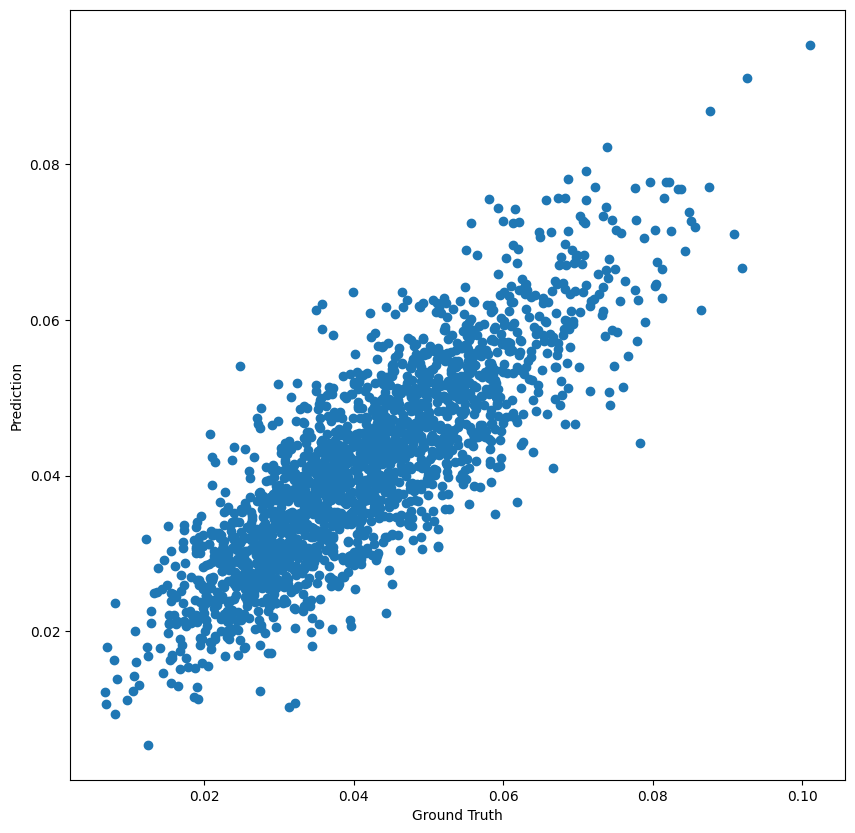

In [32]:
avg_loss_test, y_pred,y_true = evaluate(model,test_loader,criterion)
print(f"Validation Loss is {avg_loss_test:.15f}")

plt.figure(figsize=(10,10))
plt.scatter(y_true, y_pred)
plt.xlabel("Ground Truth")
plt.ylabel("Prediction")
plt.show()

In [34]:
torch.save(model.state_dict(), "/content/Regression_m.pth")